In [49]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)


### Load Data

In [50]:
# dataset
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"

# read into table
temp <- tempfile()
download.file(url,temp)
raw_data <- read_csv2(unz(temp, "student-mat.csv"))
#print.data.frame(head(raw_data))     # print.data.frame is needed because the table is wide and has collapsed columns

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



### Clean Data

In [51]:
#select columns and combine grades
data <- raw_data %>%
    select (romantic, age, absences, G1, G2, G3) %>%
    mutate (overall_grade = G1 + G2 + G3) %>%
    select (-G1, -G2, -G3) %>%
    mutate(romantic = as_factor(romantic))

data

romantic,age,absences,overall_grade
<fct>,<dbl>,<dbl>,<dbl>
no,18,6,17
no,17,4,16
no,15,10,25
⋮,⋮,⋮,⋮
no,21,3,25
no,18,0,33
no,19,5,26


### Split training and testing

In [52]:
data_split <- initial_split(data, prop = 0.75, strata = romantic)  
data_train <- training(data_split)   
data_test <- testing(data_split)

#data_train
#data_test

### Recipe

In [53]:
student_recipe <- recipe(romantic ~ ., data = data_train) %>% 
                    step_scale(all_predictors()) %>%
                    step_center(all_predictors())

### Set 5 fold

In [54]:
data_vfold <- vfold_cv(data_train, v = 5, strata = romantic)

### Spec with tune

In [55]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors= tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")

### KNN

In [56]:
set.seed(3)
knn_results <- workflow() %>%
      add_recipe(student_recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = data_vfold, grid = 10) %>%
      collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.6297915,5,0.02677848,Model1
2,roc_auc,binary,0.5948961,5,0.03288554,Model1
3,accuracy,binary,0.6332983,5,0.02871105,Model2
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,roc_auc,binary,0.5790150,5,0.05663439,Model8
15,accuracy,binary,0.6500214,5,0.01320033,Model9
15,roc_auc,binary,0.5739465,5,0.04575568,Model9


### check knn

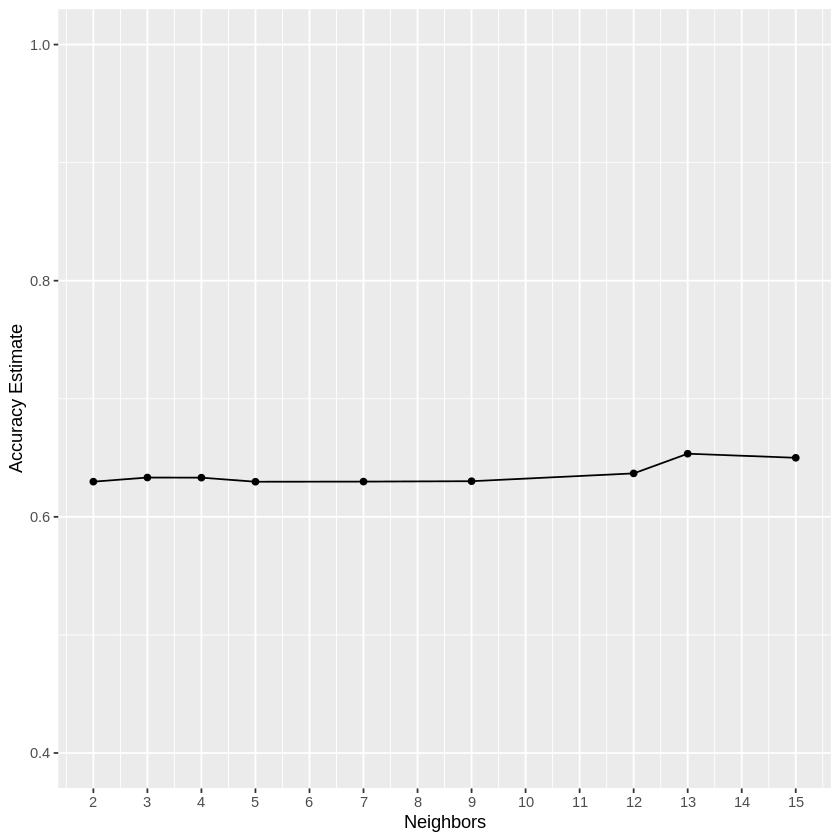

In [57]:
accuracies <- knn_results %>% 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 20, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracy_versus_k


In [41]:
max_k <- knn_results %>%
    filter(.metric =="accuracy") %>%
    arrange(desc(mean))
max_k

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
8,accuracy,binary,0.6601890,5,0.01962065,Model5
7,accuracy,binary,0.6568556,5,0.02227994,Model4
15,accuracy,binary,0.6566277,5,0.01185632,Model9
⋮,⋮,⋮,⋮,⋮,⋮,⋮
4,accuracy,binary,0.6296162,5,0.01672407,Model2
2,accuracy,binary,0.6236411,5,0.02823700,Model1
5,accuracy,binary,0.6227801,5,0.01761848,Model3


In [42]:
student_recipe <- recipe(romantic ~ ., data = data_train) %>%      #variety ~ factor1 + factor2 + ... to manually pick
                    step_scale(all_predictors()) %>%
                    step_center(all_predictors())

student_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 8) %>%
                set_engine("kknn") %>%
                set_mode("classification")

student_workflow <- workflow() %>%
                    add_model(student_model) %>%
                    add_recipe(student_recipe)

student_fit <- fit(student_workflow, data = data_train)


student_test_predictions <- predict(student_fit , data_test) %>%
      bind_cols(data_test)
student_test_predictions

.pred_class,romantic,age,absences,overall_grade
<fct>,<fct>,<dbl>,<dbl>,<dbl>
no,no,15,2,31
no,no,16,4,42
no,no,15,0,42
⋮,⋮,⋮,⋮,⋮
no,no,18,2,26
no,yes,18,0,45
yes,no,19,0,11


In [43]:
student_prediction_accuracy <- student_test_predictions %>%
        metrics(truth = romantic, estimate = .pred_class)       
student_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939
kap,binary,0.3255691
